Student Name: Christian Jones

Student ID: 23294876

# Dataset: Medical Costs billed by Health Insurance
## Import libraries

In [235]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, RobustScaler, FunctionTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
from sklearn.feature_selection import SelectKBest
import pickle
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

%matplotlib inline

In [236]:
import warnings
warnings.filterwarnings('ignore')

## Data summary

Column|Description|Type|Categories
-|-|-|-
Age|Age of beneficiary|numeric
Sex|Insurance contractor gender|categorical|male or female
BMI||numeric|
Children||numeric
Smoker||binary|yes or no
Region|US only|categorical| northeast, southeast, southwest or northwest
Charges|Medical costs billed by insurance|numeric|


In [237]:
df = pd.read_csv("./insurance.csv")
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [238]:
df['insurance_cost_binary'] = (df['insurance_cost'] > df['insurance_cost'].median()).astype(int)

In [239]:
df = df.drop(columns=['insurance_cost'])
df.describe()

,age,bmi,children,insurance_cost_binary
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,0.500000
std,14.049960,6.098187,1.205493,0.500187
min,18.000000,15.960000,0.000000,0.000000
25%,27.000000,26.296250,0.000000,0.000000
50%,39.000000,30.400000,1.000000,0.500000
75%,51.000000,34.693750,2.000000,1.000000
max,64.000000,53.130000,5.000000,1.000000


Check for missing numerical data

In [240]:
df.isna().sum()

age                      0
gender                   0
bmi                      0
children                 0
smoker                   0
region                   0
insurance_cost_binary    0
dtype: int64

Check for missing categorical data (none missing for gender, smoker and region)

In [241]:
print(df['gender'].value_counts())
print(df['smoker'].value_counts())
print(df['region'].value_counts())

male      676
female    662
Name: gender, dtype: int64
no     1064
yes     274
Name: smoker, dtype: int64
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64


In [242]:
# replace smoker: yes/no with 1/0
df['smoker'] = df['smoker'].replace({'yes': 1, 'no': 0})
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost_binary
1333,64,female,31.825,2,0,northeast,1
1334,64,female,26.885,0,1,northwest,1
1335,64,male,26.410,0,0,northeast,1
1336,64,male,36.960,2,1,southeast,1
1337,64,male,23.760,0,1,southeast,1


In [243]:
preprocess_pipeline = ColumnTransformer(
    transformers = [
        ('scale', MinMaxScaler(), ['age', 'bmi', 'children']),
        ('encode_gender', OneHotEncoder(drop='first', sparse_output=False), ['gender', 'region'])
    ],
    remainder="passthrough"
).set_output(transform="pandas")

In [244]:
df_transformed = preprocess_pipeline.fit_transform(df);

In [245]:
df_transformed.head()

,scale__age,scale__bmi,scale__children,encode_gender__gender_male,encode_gender__region_northwest,encode_gender__region_southeast,encode_gender__region_southwest,remainder__smoker,remainder__insurance_cost_binary
0,0.0,0.479150,0.2,1.0,0.0,1.0,0.0,0,0
1,0.0,0.488028,0.0,1.0,0.0,1.0,0.0,0,0
2,0.0,0.278585,0.0,0.0,0.0,0.0,0.0,0,0
3,0.0,0.610842,0.4,0.0,0.0,0.0,0.0,0,0
4,0.0,0.529056,0.0,0.0,0.0,0.0,0.0,0,0


In [246]:
df_transformed.describe()

,scale__age,scale__bmi,scale__children,encode_gender__gender_male,encode_gender__region_northwest,encode_gender__region_southeast,encode_gender__region_southwest,remainder__smoker,remainder__insurance_cost_binary
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,0.461022,0.395572,0.218984,0.505232,0.242900,0.272048,0.242900,0.204783,0.500000
std,0.305434,0.164062,0.241099,0.500160,0.428995,0.445181,0.428995,0.403694,0.500187
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.195652,0.278080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.456522,0.388485,0.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.500000
75%,0.717391,0.504002,0.400000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [247]:
X = df.drop(columns=['insurance_cost_binary'])
y = df['insurance_cost_binary']

Split data into training and testing before applying pre-processing to avoid data leakage into the test dataset.

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Classification

1. For each classifier (SVM, Random Forest and MLPClassifier), include data preparation and dimensionality reduction steps in the main pipeline.
2. For the dimensionality reduction step use PCA, RFE and a third dimensionality reduction (incl. feature selection) technique in at least one pipeline.
3. Use grid search for hyperparameter tuning and replicate the process in the example notebook Tutorial 3-1 - Binary 
4. Classification.ipynb to evaluate and compare the models you have trained and pick the best one.
5. Summarise your experience in a markdown cell (max 150 words in a markdown cell).

### Support Vector Classification Pipeline

The SVM pipeline has been run using different numbers for dimension reduction.

In [257]:
for dimension in range(2, 7):
    pipe = Pipeline(steps=[
        ('preprocess', preprocess_pipeline), 
        ('reduction', PCA(n_components=dimension)),
        ('svm', svm.SVC( random_state=1) )
    ])

    param_grid = {
        'svm__C': [0.1, 1, 10, 100],  
        'svm__gamma': [1, 0.1, 0.01, 0.001], 
        'svm__kernel': ['rbf', 'linear', 'poly']}

    search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
    search.fit(X_train, y_train) #training happens here! SVM is trained 48x5 = 240 times

    print("Best CV score = %0.3f:" % search.best_score_)
    print("Best parameters: ", search.best_params_)

    # store the best params and best model for later use
    SVM_best_params = search.best_params_
    SVM_best_model = search.best_estimator_

252662.90s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
252662.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
252662.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
252662.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
252662.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
252662.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
252662.98s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
252662.99s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debuggi

Best CV score = 0.667:
Best parameters:  {'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
Best CV score = 0.717:
Best parameters:  {'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
Best CV score = 0.850:
Best parameters:  {'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
Best CV score = 0.931:
Best parameters:  {'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
Best CV score = 0.931:
Best parameters:  {'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'rbf'}


Introducing dimensional reduction using PCA with 2 components, signficantly reduced score from 0.934 to 0.685. Results are tabulated below, and in the case of 5 dimensions, poly instead of rbf was the optimal kernel, after re-running this was no longer the case, so it's important to set random_state prior to perform such comparisons, as the cross validation samples will otherewise be different each time.

Dimensions|Best CV scores|Optimal kernel
-|-|-
2|0.667|rbf
3|0.717|rbf
4|0.850|rbf
5|0.931|rbf
6|0.931|rbf


### Random Forest Pipeline

For the Random Forest pipeline we will take a look at the various different options for dimensionality reduction: 
PCA, RFE and SelectKBest

In [250]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                    #    ('reduction_PCA', PCA(n_components=5)),
                        # ('reduction_RFE', RFE(estimator=svm.SVC(kernel='linear'), n_features_to_select=5)),
                        ('reduction_selectKBest', SelectKBest(k=5)),
                       ('rf', RandomForestClassifier())
                       ])

param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.923:
Best parameters:  {'rf__max_depth': 8, 'rf__n_estimators': 30}


Reduction by PCA (principle component analysis)
Best CV score = 0.930:
Best parameters:  {'rf__max_depth': 6, 'rf__n_estimators': 30}

Reduction by RFE (recursive feature elimination)
Best CV score = 0.920:
Best parameters:  {'rf__max_depth': 4, 'rf__n_estimators': 30}

Reduction by Select K Best
Best CV score = 0.915:
Best parameters:  {'rf__max_depth': 4, 'rf__n_estimators': 20}

While PCA provided a better cross validation score of 0.930 compared with the other two dimensionality reduction methods, it's interesting to note that the optimal parameters vary in all three cases.

### MLP Classifier

In [251]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('classifier', MLPClassifier(random_state=1, max_iter=300))
    ])

param_grid = {
    'classifier__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'classifier__activation': ['tanh', 'relu'],
    'classifier__solver': ['sgd', 'adam'],
    'classifier__alpha': [0.0001, 0.05],
    'classifier__learning_rate': ['constant','adaptive'],
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

/Users/christianjones/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/christianjones/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/christianjones/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/christianjones/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Best CV score = 0.943:
Best parameters:  {'classifier__activation': 'tanh', 'classifier__alpha': 0.05, 'classifier__hidden_layer_sizes': (50, 50, 50), 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam'}


### Determining best classifier the for insurance data

We can use the test data to evalaluate the three different models using:
- Accuracy
- Precision
- Recall
- F1 score
- True Positive rate
- AUC

In [252]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [253]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the model predicts probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [254]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, MLP_auc = evaluate_model(X_test, y_test, MLP_best_model)

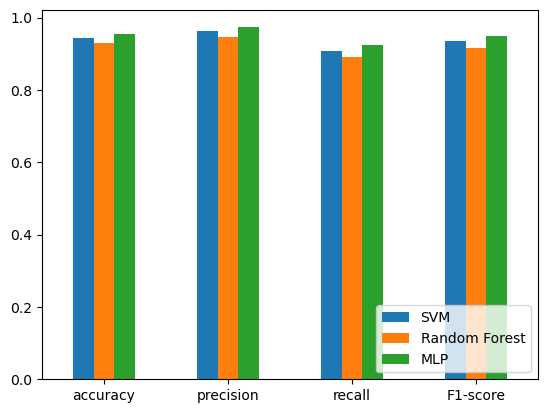

In [255]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'MLP': MLP_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

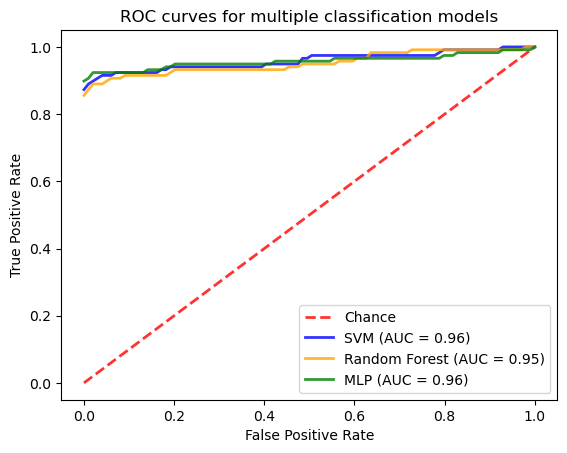

In [256]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, MLP_tpr[0,:], lw=2, color='green', label='MLP (AUC = %0.2f)' % (MLP_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classification models')
plt.legend(loc="lower right")
plt.show()

# Forum Post

## Classification
- How do SVM and Random Forest compare when trained with the insurance dataset?
Similar performance by each, however Random Forest is slightly more accurate.

- Which additional classifier have you used (or intend to use)? How does it compare to SVM and Random Forest?
MLPClassifier, similar performance as the others.

- Which parameters of the classifiers have you explored and what are the results?

- What other dimensionality reduction methods have you tried (or intend to try) and what are the results?


## Regression
- How do Random Forest and Linear Regression compare on the insurance dataset?
- Which additional regressor have you used (or intend to use)? How does it compare to Random Forest and Linear Regression?
- Which parameters of the regressors have you explored and what are the results?
- What other dimensionality reduction methods have you tried (or intend to try) and what are the results?